In [2]:
import pandas as pd
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile
from io import StringIO
import random

In [3]:
# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import numpy as np

In [4]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

In [5]:
headers = ['Class', 'CapShape','CapSurface', 'CapColor','Bruises', 'Odor','GillAttachment',
           'GillSpacing','GillSize','GillColor','StalkShape', 'StalkRoot','StalkAboveRing', 
           'StalkBelowRing','ColorAboveRing', 'ColorBelowRing','VeilType', 'VeilColor',
           'RingNumber', 'RingType','SporeColor','Population','Habitat']

mushroom_dataset_raw = pd.read_csv("dataset/agaricus-lepiota.data",header = None,names = headers,
                      sep = ',',na_values=["?"],engine='python')

mushroom_dataset_raw.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
mushroom_dataset_raw.describe()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [7]:
mushroom_dataset_raw.shape

(8124, 23)

<Axes: >

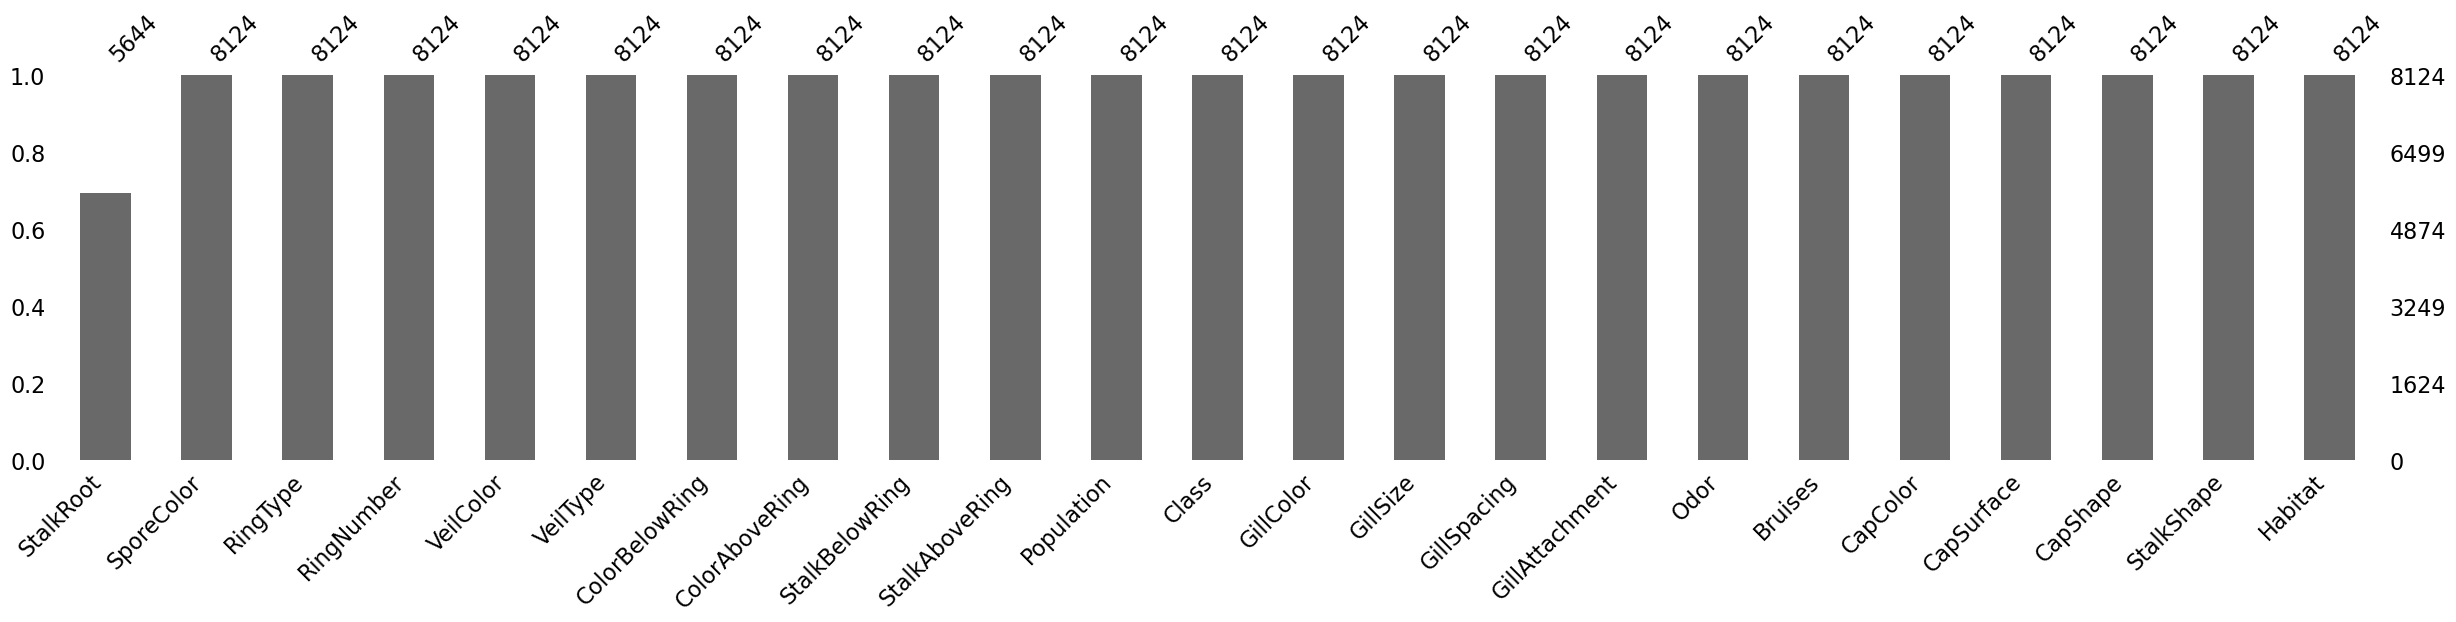

In [8]:
missingno.bar(mushroom_dataset_raw, sort='ascending', figsize = (30,5))

### Feature Cleaning and Imputation 
Identifying and handling inconsistencies, errors, or missing values in the dataset's features aims to ensure that the data is of high quality and suitable for analysis or modeling.

In [9]:
mushroom_dataset_bin = pd.DataFrame()

In [10]:
mushroom_dataset_raw.loc[mushroom_dataset_raw['Class'] == 'e', 'Class'] = 1
mushroom_dataset_raw.loc[mushroom_dataset_raw['Class'] == 'p', 'Class'] = 0
mushroom_dataset_bin['Class'] = mushroom_dataset_raw['Class']

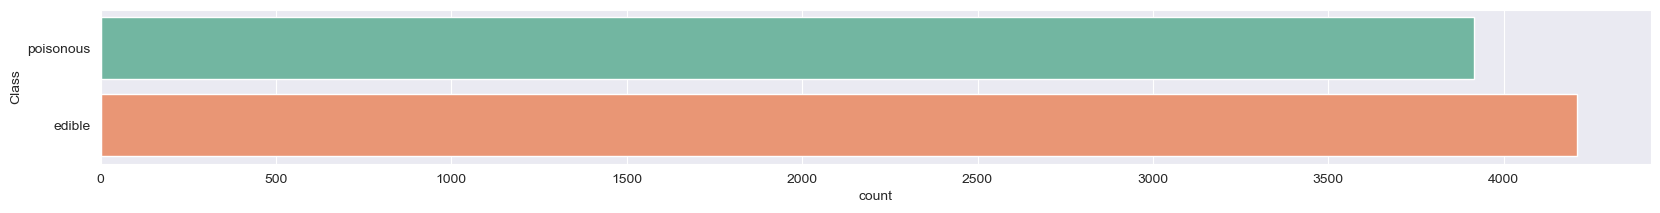

In [11]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(20, 2)) 
g = sns.countplot(y="Class", data=mushroom_dataset_bin, palette="Set2")
g.set_yticklabels(['poisonous', 'edible'])
plt.show()

In [12]:
mushroom_dataset_bin['CapShape'] = mushroom_dataset_raw['CapShape']
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'b', 'CapShape'] = 'bell'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'c', 'CapShape'] = 'conical'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'x', 'CapShape'] = 'convex'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'f', 'CapShape'] = 'flat'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 'k', 'CapShape'] = 'knobbed'
mushroom_dataset_raw.loc[mushroom_dataset_raw['CapShape'] == 's', 'CapShape'] = 'sunken'

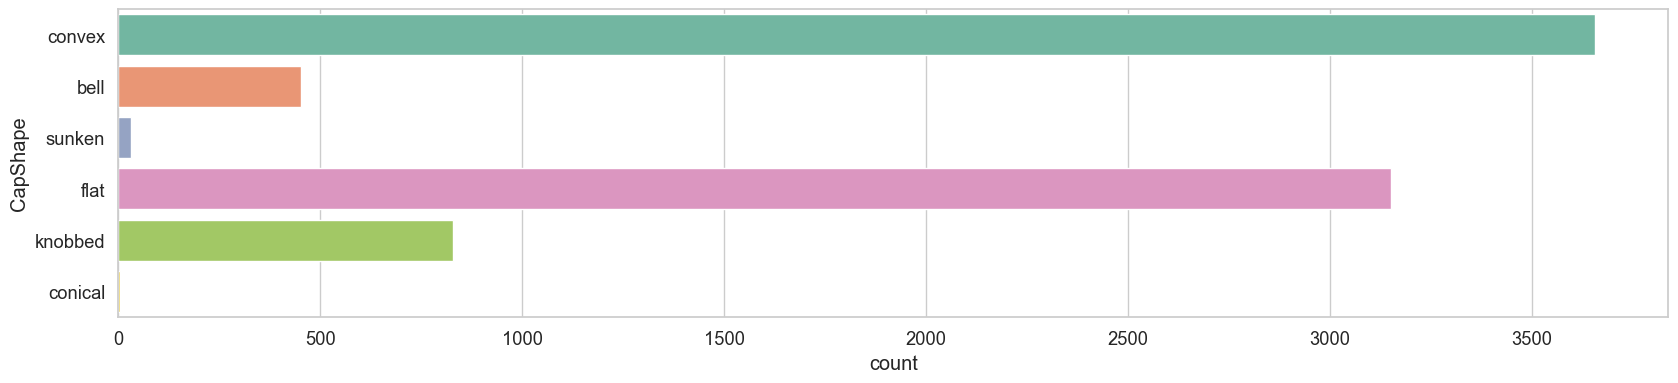

In [13]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})
g = sns.countplot(y="CapShape", data=mushroom_dataset_raw, palette="Set2");

In [14]:
mushroom_dataset_bin['Population'] = mushroom_dataset_raw['Population']
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'a', 'Population'] = 'abundant'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'c', 'Population'] = 'clustered'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'n', 'Population'] = 'numerous'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 's', 'Population'] = 'scattered'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'v', 'Population'] = 'several'
mushroom_dataset_raw.loc[mushroom_dataset_raw['Population'] == 'y', 'Population'] = 'solitary'

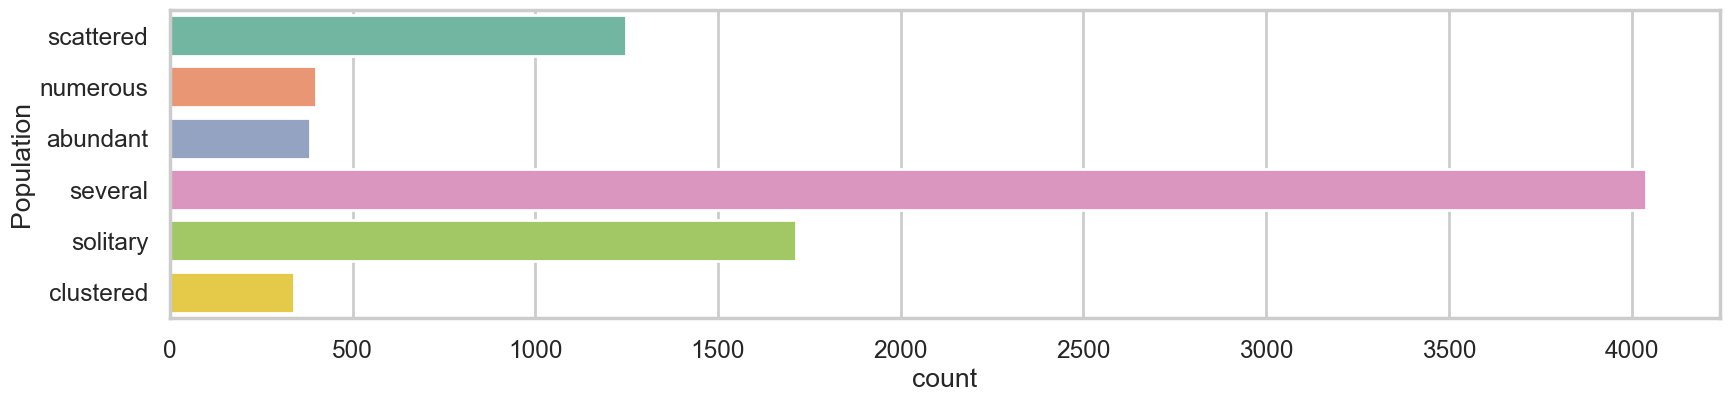

In [15]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 2})
g = sns.countplot(y="Population", data=mushroom_dataset_raw, palette="Set2");

### Feature Encoding
Converting Categorical Features into values, performing both One-Hot and Label encoding.

In [16]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = mushroom_dataset_bin.columns.tolist()
one_hot_cols.remove('Class')
dataset_bin_enc = pd.get_dummies(mushroom_dataset_bin, columns=one_hot_cols)
dataset_bin_enc.head()

,Class,CapShape_b,CapShape_c,CapShape_f,CapShape_k,CapShape_s,CapShape_x,Population_a,Population_c,Population_n,Population_s,Population_v,Population_y
0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,1,0,0,0,0,0


In [17]:
dataset_con_enc = pd.DataFrame({col: mushroom_dataset_raw[col].astype('category').cat.codes for col in mushroom_dataset_raw}, index=mushroom_dataset_raw.index)
dataset_con_enc.head()

,Class,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
0,0,2,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,1,2,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,1,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,0,2,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,1,2,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


### Correlation

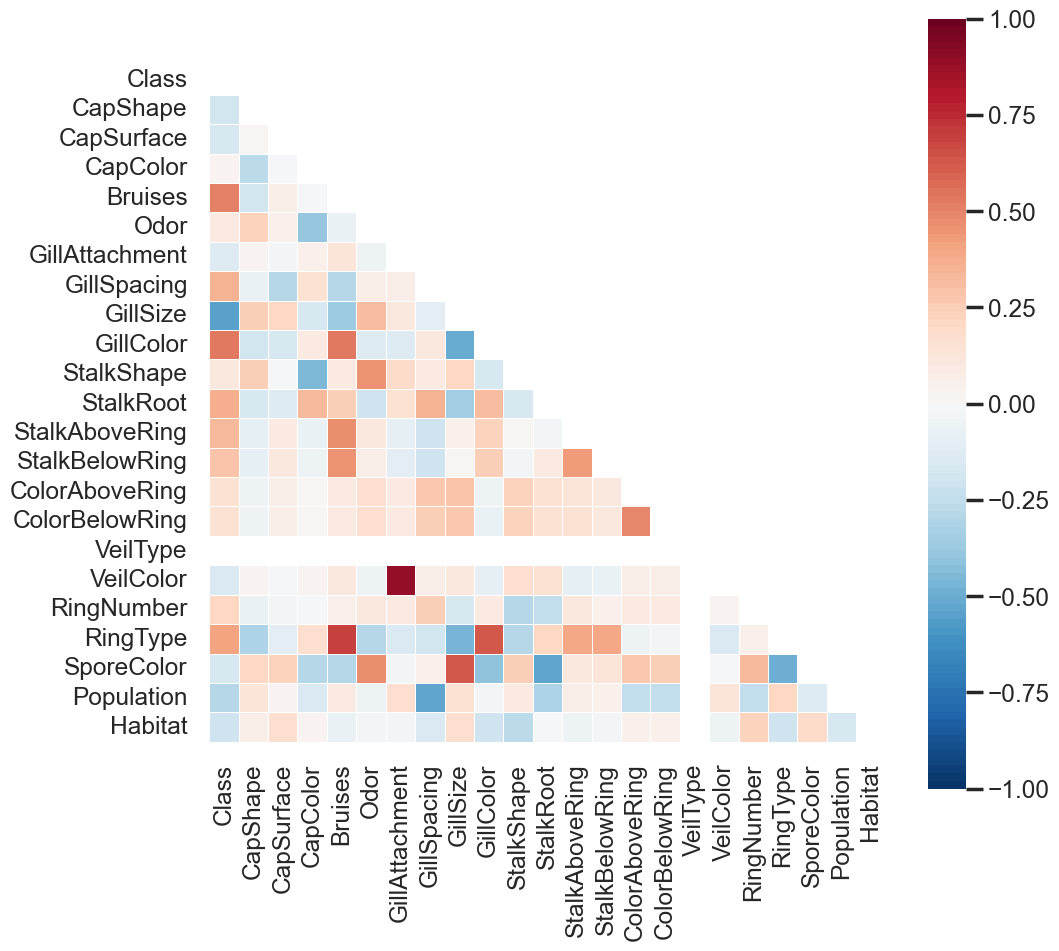

In [18]:
sns.set_style('white')
fig = plt.figure(figsize=(24,10))

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance


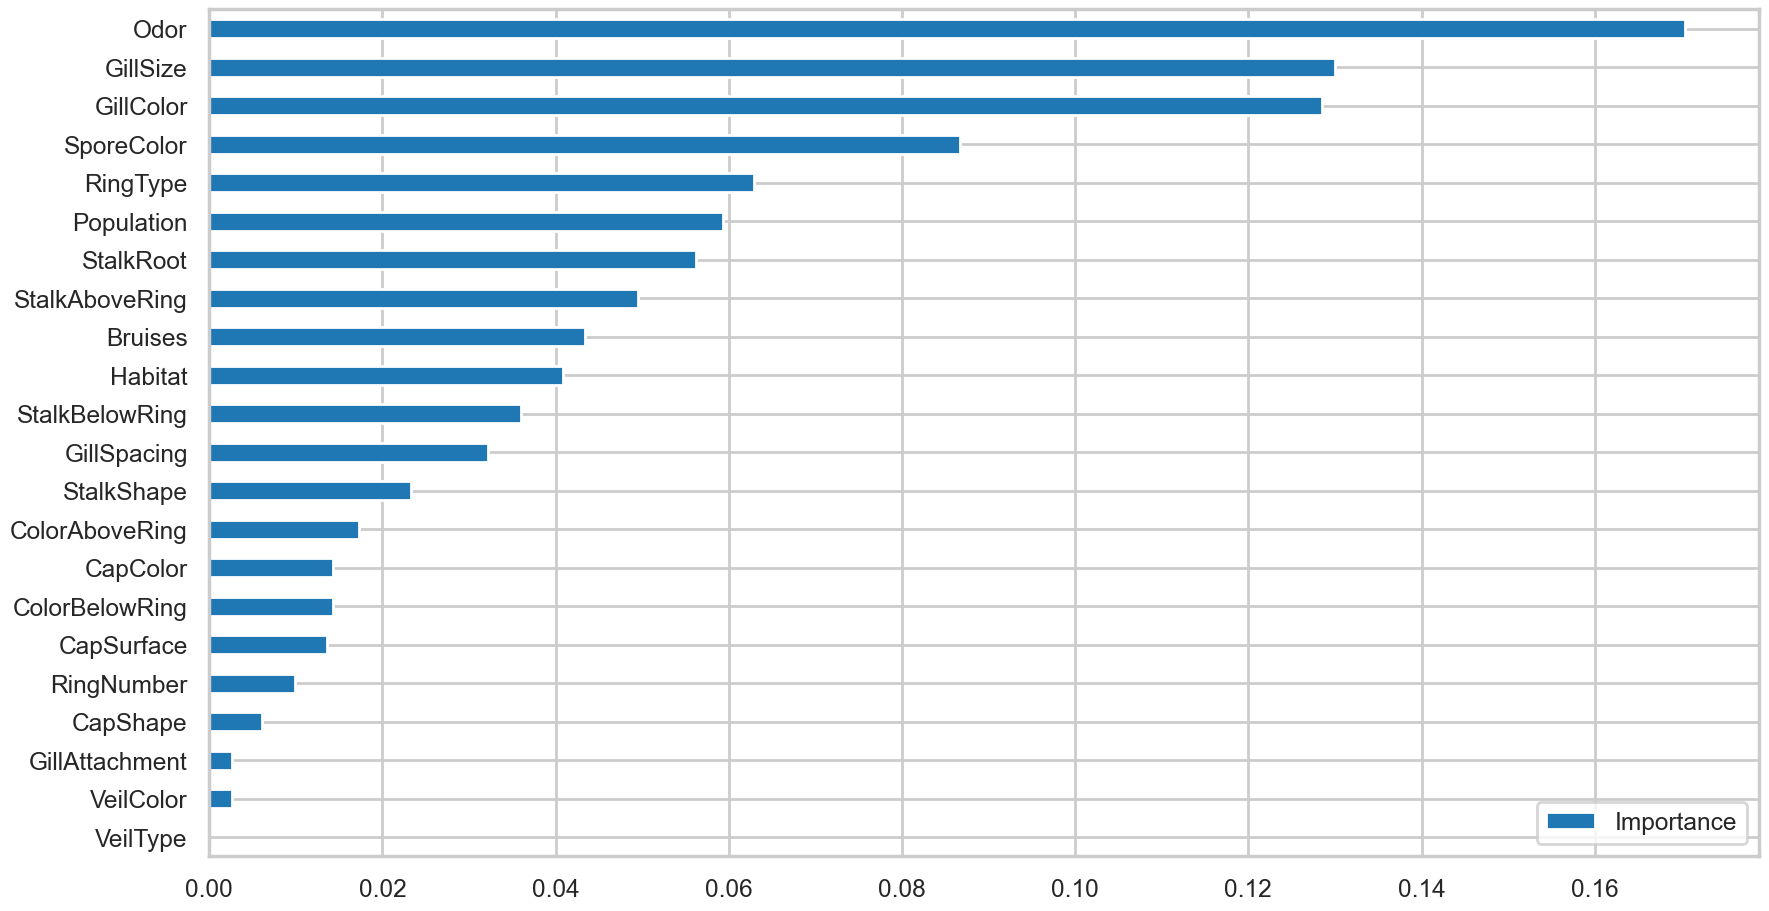

In [19]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('Class', axis=1), dataset_con_enc['Class'])

sns.set_style('whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('Class', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

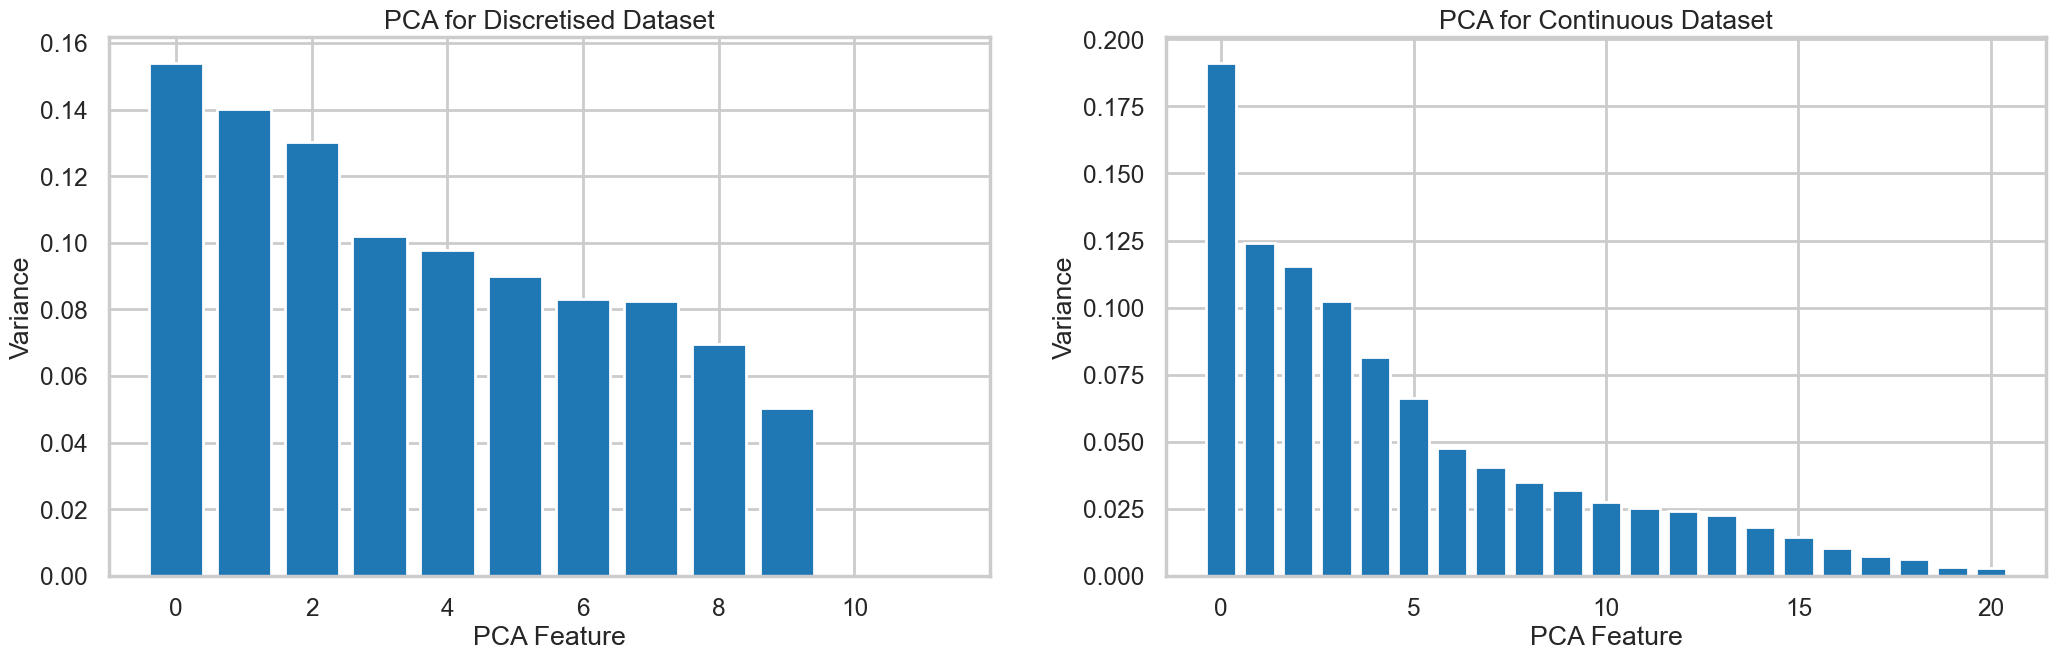

In [20]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('Class', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('Class', axis=1))
X = std_scale.transform(dataset_con_enc.drop('Class', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
sns.set_style('whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

### Splitting Data into Training and Testing Datasets

In [21]:
train = dataset_con_enc.sample(frac=0.7)
test = dataset_con_enc.loc[~dataset_con_enc.index.isin(train.index)]
print(train.shape)
print(test.shape)

(5687, 23)
(2437, 23)


### Removing Missing Values 

In [22]:
train = train.dropna(axis=0)
test = test.dropna(axis=0)
print(f'Training data set shape :  {train.shape}')
print(f'Testing  data set shape :  {test.shape}')

Training data set shape :  (5687, 23)
Testing  data set shape :  (2437, 23)


In [23]:
X_train_w_label = train
X_train = train.drop(['Class'], axis=1)
y_train = train['Class'].astype('int64')
X_test = test.drop(['Class'], axis=1)
y_test = test['Class'].astype('int64')

In [24]:
X_train.shape
X_train.head()

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,...,StalkBelowRing,ColorAboveRing,ColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporeColor,Population,Habitat
6333,2,2,2,0,2,1,0,1,0,1,...,2,7,6,0,2,1,0,7,4,2
1964,3,2,8,0,5,1,1,0,3,1,...,0,7,7,0,2,1,0,3,0,1
6714,3,3,2,0,7,1,0,1,0,1,...,2,6,7,0,2,1,0,7,4,0
893,0,2,9,1,0,1,0,0,2,0,...,2,7,7,0,2,1,4,3,3,3
232,2,3,9,1,3,1,0,0,5,0,...,3,7,7,0,2,1,4,3,5,4


In [25]:
y_train.head()

6333    0
1964    1
6714    0
893     1
232     1
Name: Class, dtype: int64

In [26]:
random.seed(10)

### Decision Tree 

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_clf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 1.0


### Artificial Neural Network 


In [31]:
import Tensorlfow
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Assuming you have already loaded and preprocessed your data into X_train, X_test, y_train, y_test

# Define the architecture of the neural network
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test data
y_pred_ann = model.predict_classes(X_test)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print("ANN Accuracy:", accuracy_ann)


ModuleNotFoundError: No module named 'Tensorlfow'